In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [0]:
# import package
import matplotlib.pyplot as plt
import numpy as np
import os

In [0]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Dense, Dropout, Activation,
                                     BatchNormalization, Flatten,
                                     Conv2D, MaxPooling2D)

In [6]:
# cifar10 中有將 data 先分為 train 和 test
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print('y_train.shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# x_train.shape: 四個維度：第 1 維度為筆數、第 2, 3 維度為影像大小 32*32、第 4 維度是 RGB 三原色，所以是 3
# x_train 中有 50000 筆訓練資料，以及 x_test 中有 10000 筆的測試資料

170500096/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train.shape: (50000, 1)
50000 train samples
10000 test samples


[0 1 2 3 4 5 6 7 8 9] [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]


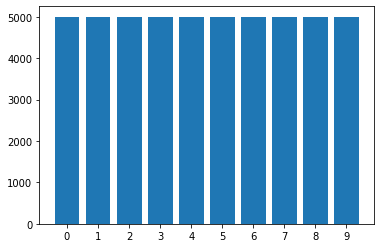

In [7]:
uniques, counts = np.unique(y_train, return_counts=True)
print(uniques, counts)

plt.bar(uniques, counts)
plt.xticks(uniques)
plt.show()

[0 1 2 3 4 5 6 7 8 9] [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


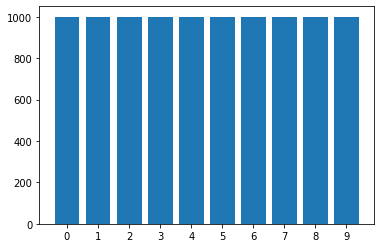

In [8]:
uniques, counts = np.unique(y_test, return_counts=True)
print(uniques, counts)

plt.bar(uniques, counts)
plt.xticks(uniques)
plt.show()

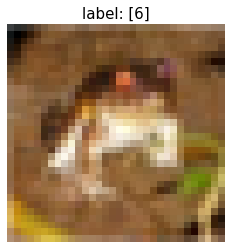

In [9]:
plt.imshow(x_train[0])
plt.title("label: {}".format(y_train[0]), fontsize=15)     # 第 0 筆圖像資料分類的位置
plt.axis("off")
plt.show()

In [10]:
x_train.dtype

dtype('uint8')

In [0]:
# 記得轉成 'float32'
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# 將 features (照片影像特徵值) 標準化，可以提高模型預測的準確度，並且更快收斂
x_train /= 255  # rescaling
x_test /= 255   # rescaling

In [12]:
y_train[0:10]    # 0:10筆的類別

array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3]], dtype=uint8)

In [13]:
keras.utils.to_categorical(y_train[0:10])  # 對 0:10 筆的類別做 one_hot
# np.eye(10)[y_train[0:10]]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [14]:
# 將訓練資料與測試資料的 label，進行 Onehot encoding 轉換
num_classes = 10
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

y_train = np.eye(num_classes, dtype='float32')[y_train[:, 0]]
y_test = np.eye(num_classes, dtype='float32')[y_test[:, 0]]

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (50000, 10)
y_test shape: (10000, 10)


DNN Model

In [0]:
dnn_model = Sequential()

dnn_model.add(Flatten(input_shape=x_train.shape[1:]))
dnn_model.add(Dense(512))
dnn_model.add(BatchNormalization())
dnn_model.add(Activation('relu'))
dnn_model.add(Dropout(rate=0.25))
dnn_model.add(Dense(256))
dnn_model.add(BatchNormalization())
dnn_model.add(Activation('relu'))
dnn_model.add(Dropout(rate=0.25))
dnn_model.add(Dense(128))
dnn_model.add(BatchNormalization())
dnn_model.add(Activation('relu'))
dnn_model.add(Dropout(rate=0.25))
dnn_model.add(Dense(num_classes))
dnn_model.add(Activation('softmax'))

In [16]:
print(dnn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

CNN Model

In [0]:
# 選擇 Keras 的 API 寫法
inputs = Input(shape=x_train.shape[1:])

# 第一層
# 建立卷積層，設定32個3*3的filters
# 設定ReLU為激活函數。
x = Conv2D(32, (3, 3), activation='relu')(inputs)

# 第二層 - 卷積層 + 池化層
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# 第三層 - 卷積層
x = Conv2D(64, (3, 3), activation='relu')(x)

# 第四層 - 卷積層 + 池化層
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# 建立分類模型 (MLP) : 平坦層 + 輸出層 (10)
x = Flatten()(x)
outputs = Dense(num_classes, activation='softmax')(x)


cnn_model = Model(inputs=inputs, outputs=outputs)

In [18]:
print(cnn_model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0     

In [0]:
# 編譯模型
# 選用 Adam 為 optimizer
learning_rate = 0.0001
optimizer = keras.optimizers.Adam(lr=learning_rate)

dnn_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

開始訓練模型

In [0]:
batch_size = 32
epochs = 20

In [0]:
dnn_history = dnn_model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            verbose=1,
                            shuffle=True)

cnn_history = cnn_model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            verbose=2)

Epoch 1/20
1563/1563 [==============================] - 25s 16ms/step - loss: 1.9694 - accuracy: 0.3079 - val_loss: 1.6496 - val_accuracy: 0.4169
Epoch 2/20
1563/1563 [==============================] - 24s 16ms/step - loss: 1.7362 - accuracy: 0.3842 - val_loss: 1.5917 - val_accuracy: 0.4333
Epoch 3/20
1563/1563 [==============================] - 24s 15ms/step - loss: 1.6408 - accuracy: 0.4171 - val_loss: 1.5036 - val_accuracy: 0.4656
Epoch 4/20
1563/1563 [==============================] - 25s 16ms/step - loss: 1.5814 - accuracy: 0.4383 - val_loss: 1.5247 - val_accuracy: 0.4487
Epoch 5/20
1563/1563 [==============================] - 24s 15ms/step - loss: 1.5255 - accuracy: 0.4547 - val_loss: 1.4528 - val_accuracy: 0.4787
Epoch 6/20
1563/1563 [==============================] - 24s 16ms/step - loss: 1.4933 - accuracy: 0.4667 - val_loss: 1.4458 - val_accuracy: 0.4820
Epoch 7/20
1563/1563 [==============================] - 24s 15ms/step - loss: 1.4565 - accuracy: 0.4826 - val_loss: 1.5085 -

測試資料

In [0]:
test_pred = cnn_model.predict(x_test[0:1]).argmax(-1)

plt.imshow(x_test[0])
print('prediction: ', test_pred)

In [0]:
print(y_test[0])

In [0]:
dnn_loss, dnn = dnn_model.evaluate(x_test, y_test, verbose=2)
cnn_pred = cnn_model.evaluate(x_test, y_test, verbose=2)

訓練結果視覺化

In [0]:
history_list = [cnn_history, dnn_history]
history_name = ["cnn_history", "dnn_history"]

In [0]:
# training loss
for each_his, each_name in zip(history_list, history_name):
    l_x = len(each_his.history['loss'])
    plt.plot(np.arange(l_x), each_his.history['loss'], label=each_name)
plt.legend(loc='best')
plt.title('training_loss')
plt.show()

# training acc
for each_his, each_name in zip(history_list, history_name):
    l_x = len(each_his.history['accuracy'])
    plt.plot(np.arange(l_x), each_his.history['accuracy'], label=each_name)
plt.legend(loc='best')
plt.title('training_acc')
plt.show()

# valid loss
for each_his, each_name in zip(history_list, history_name):
    l_x = len(each_his.history['val_loss'])
    plt.plot(np.arange(l_x), each_his.history['val_loss'], label=each_name)
plt.legend(loc='best')
plt.title('val_loss')
plt.show()


# valid acc
for each_his, each_name in zip(history_list, history_name):
    l_x = len(each_his.history['val_accuracy'])
    plt.plot(np.arange(l_x), each_his.history['val_accuracy'], label=each_name)
plt.legend(loc='best')
plt.title('val_acc')
plt.show()